In [ ]:
# http://numericinsight.com/uploads/A_Gentle_Introduction_to_Backpropagation.pdf

In [ ]:
# doing Neural Network (MLP)

## structure: 1 x 3 x 1
### 1 inputs :: 1 hidden layer with 3 units :: 1 outputs

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sys

In [124]:
def ground_prediction(x1_i, x2_i):
    ground = x1_i + x2_i
    return ground
    
    
n_samples = 1000
X1 = np.random.choice(np.random.randint(0, 10000, 10000), n_samples)
X2 = np.random.choice(np.random.randint(10000, 20000, 10000), n_samples)
X = np.asarray([X1, X2]).transpose()

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X)
X_norm = scaler.transform(X)

y = list()
for i in np.arange(X.shape[0]):
    y_i = ground_prediction(X[i,0], X[i,1])
    y.append(y_i)
    
y = np.asarray(y) 
y = y.reshape(-1,1)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
scaler_y.fit(y)
y_norm = scaler_y.transform(y)

In [125]:
# Initialize Weight Layers
def initialize_layers():
    # +1 represents bias purposes
    X_feat_n = X.shape[1]
    L1_units_n = X_feat_n
    L2_units_n = 3
    L3_units_n = 1
    
    L1_weights = np.random.randn(L2_units_n*(L1_units_n + 1))
    L1_weights = L1_weights.reshape(L2_units_n, (L1_units_n + 1))

    L2_weights = np.random.randn(L3_units_n, (L2_units_n + 1))
    L2_weights = L2_weights.reshape(L3_units_n, (L2_units_n + 1))

    return L2_weights, L1_weights



In [126]:
def sigmoid_fun(z):
    activation = 1 / (1 + np.exp(-z))
    return activation
 

def sigmoid_fun_derivative(a):
    derv = np.multiply(a, (1.0 - a))
    return derv
    
    
def add_bias(a_matrix):
    a_matrix = np.row_stack((np.ones(a_matrix.shape[1]), a_matrix))
    return a_matrix


def compute_mean_squared_error(a_3, idx):
    y_3 = y_norm[idx].reshape(a_3.shape)
    err = 0.5*np.power(y_3 - a_3, 2)
    
    err = np.sum(err)/batch_size
    return err

In [127]:
def compute_backpropagation_errors(a_3, a_2):    
    #d_3 = np.multiply((a_3 - y[idx].reshape(a_3.shape)), sigmoid_fun_derivative(a_3))
    d_3 = a_3 - y_norm[idx].reshape(a_3.shape)
    
    # remove the bias column of weights and its activation
    d_2 = np.multiply(L2_weights[:, 1:].transpose().dot(d_3), sigmoid_fun_derivative(a_2[1:]))
    
    return d_3, d_2


def compute_gradient(d, a):
    grad = d.dot(a.transpose()) / batch_size
    return grad
    

def update_weights(a_3, a_2, a_1, check_grad=False):
    #import pdb; pdb.set_trace()
    d_3, d_2 = compute_backpropagation_errors(a_3, a_2)
    
    grad_L2 = compute_gradient(d_3, a_2)
    grad_L1 = compute_gradient(d_2, a_1)
    
    L2_weights_updated = L2_weights - r * grad_L2
    L1_weights_updated = L1_weights - r * grad_L1
    
    if (check_grad):
        check_gradient(L2_weights, grad_L2, L1_weights, grad_L1)
    
    return L2_weights_updated, L1_weights_updated


def feed_forward_NN(L2_weights, L1_weights, idx):
    #import pdb; pdb.set_trace()

    a_1 = X_norm[idx].transpose()
    a_1 = add_bias(a_1)
    
    z_2 = L1_weights.dot(a_1)
    a_2 = sigmoid_fun(z_2)
    a_2 = add_bias(a_2)
    
    z_3 = L2_weights.dot(a_2)
    #a_3 = sigmoid_fun(z_3)
    a_3 = z_3
    
    return a_3, a_2, a_1

In [128]:
def compute_gradient_approximation(L2_weights, L1_weights, e):
    # 2nd layer
    L2_weights_gradsAprox = np.zeros(L2_weights.shape)
    for i in np.arange(L2_weights.shape[0]):
        for j in np.arange(L2_weights.shape[1]):
            L2_weights_shift = np.copy(L2_weights)
            
            L2_weights_shift[i,j] = L2_weights[i,j] + e
            a_3, a_2, a_1 = feed_forward_NN(L2_weights_shift, L1_weights, idx)
            err_plus = compute_mean_squared_error(a_3, idx)

            L2_weights_shift[i,j] = L2_weights[i,j] - e
            a_3, a_2, a_1 = feed_forward_NN(L2_weights_shift, L1_weights, idx)
            err_minus = compute_mean_squared_error(a_3, idx)
    
            derv = (err_plus - err_minus)/(2*e)
            L2_weights_gradsAprox[i,j] = derv
            
           
    # 1st layer
    L1_weights_gradsAprox = np.zeros(L1_weights.shape)
    for i in np.arange(L1_weights.shape[0]):
        for j in np.arange(L1_weights.shape[1]):
            L1_weights_shift = np.copy(L1_weights)
            
            L1_weights_shift[i,j] = L1_weights[i,j] + e
            a_3, a_2, a_1 = feed_forward_NN(L2_weights, L1_weights_shift, idx)
            err_plus = compute_mean_squared_error(a_3, idx)

            L1_weights_shift[i,j] = L1_weights[i,j] - e
            a_3, a_2, a_1 = feed_forward_NN(L2_weights, L1_weights_shift, idx)
            err_minus = compute_mean_squared_error(a_3, idx)
    
            derv = (err_plus - err_minus)/(2*e)
            L1_weights_gradsAprox[i,j] = derv
            
            
    return L2_weights_gradsAprox, L1_weights_gradsAprox
    


def check_gradient(L2_weights, grad_L2, L1_weights, grad_L1, e=1e-4):
        
    L2_weights_gradsAprox, L1_weights_gradsAprox = compute_gradient_approximation(L2_weights, L1_weights, e)
    
    L2_grads_check = np.allclose(L2_weights_gradsAprox, grad_L2, atol=1e-3)
    if not (L2_grads_check): sys.exit("Error in L2 gradients values checking ")
    
    L2_grads_check_shape = (L2_weights_gradsAprox.shape == grad_L2.shape)
    if not (L2_grads_check_shape): sys.exit("Error in L2 gradients shape checking ")
        
    L1_grads_check = np.allclose(L1_weights_gradsAprox, grad_L1, atol=1e-2)    
    if not (L1_grads_check): sys.exit("Error in L1 gradients values checking")

    L1_grads_check_shape = (L1_weights_gradsAprox.shape == grad_L1.shape)
    if not (L1_grads_check_shape): sys.exit("Error in L1 gradients shape checking ")
    

In [150]:

err_history = []

itr_n = 1e4
batch_size = 500
r = 90e-3
        
L2_weights, L1_weights = initialize_layers()
print "L2_weights"
print L2_weights
print "L1_weights"
print L1_weights

CG = True
for i in np.arange(itr_n):
    idx = np.random.choice(np.arange(X.shape[0]), batch_size)
    a_3, a_2, a_1 = feed_forward_NN(L2_weights, L1_weights, idx)

    err = compute_mean_squared_error(a_3, idx)

    #print err
    err_history.append(err)
    if (i == 5): CG = False;        
    L2_weights, L1_weights = update_weights(a_3, a_2, a_1, check_grad=CG)


print ""
print L2_weights
print L1_weights   
    

L2_weights
[[ 0.15505334  0.7117675   0.10145171  1.29070653]]
L1_weights
[[ 1.51178037  1.16633675  0.01330648]
 [ 1.37712699  0.61443771  0.95080865]
 [-0.20190246 -1.22338544  1.25536653]]

[[-1.30052695  1.32049565  0.13984626  1.08100489]]
[[ 0.11151099  1.59280136  0.31995821]
 [ 1.44856551  0.49401796  0.91232369]
 [-0.17145282  0.15631962  1.70884436]]


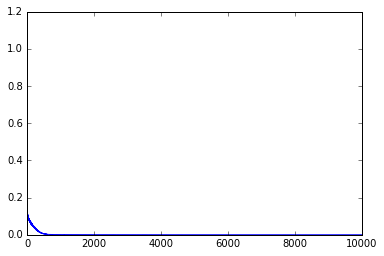

In [151]:
plt.plot(err_history)
plt.show()

In [152]:
idx = np.random.choice(np.arange(X.shape[0]), 5)
a_3, a_2, a_1 = feed_forward_NN(L2_weights, L1_weights, idx)

y_demo = y[idx]
y_demo = y_demo.reshape((5,))
a_3_demo = scaler_y.inverse_transform(a_3) 
a_3_demo = a_3_demo.reshape((5,))

for i in np.arange(y_demo.shape[0]):
    print int(y_demo[i]), int(a_3_demo[i]), (int(y_demo[i]) - int(a_3_demo[i]))


22903 23135 -232
19770 19950 -180
22277 22548 -271
23513 23813 -300
18123 17901 222


In [153]:
a_3, a_2, a_1 = feed_forward_NN(L2_weights, L1_weights, np.random.choice(np.arange(X.shape[0]), 10))
print a_3
print scaler_y.inverse_transform(a_3)

[[ 0.41731503 -0.43606    -0.04902948  0.62667192 -0.2819407   0.47211696
   0.19478532 -0.42585398 -0.26800462  0.57903749]]
[[ 24013.50682788  15723.39511686  19483.20313198  26047.30431953
   17220.58711498  24545.8802296   21851.74194966  15822.54147139
   17355.96911055  25584.55972926]]
